# SMS Spam Classification - Model Training and Evaluation

This notebook handles model training, evaluation, validation, and hyperparameter tuning.

## Approach
- Benchmark 3 models: Logistic Regression, Naive Bayes, SVM
- Use TF-IDF vectorization for text feature extraction
- Optimize for high recall while maintaining precision >= 90%
- Evaluate on held-out test set

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
import time

import mlflow
import mlflow.sklearn
from sklearn.metrics import average_precision_score as auprc_score  # AUCPR
from mlflow.tracking import MlflowClient

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("="*60)
print("SMS SPAM CLASSIFICATION - MODEL TRAINING")
print("="*60)
print("✓ All imports successful")
print("✓ Warnings suppressed")
print("✓ Visualization settings configured")

print(f"\n{'='*60}")
print("EVALUATION STRATEGY")
print(f"{'='*60}")
print("Primary Metric: Precision ≥ 90% (hard constraint)")
print("Secondary Metric: Recall (maximize spam detection)")
print("Selection Metric: F-beta (β=0.1) - extreme precision weighting")
print(f"  → With β=0.1: Precision weighs 100x more than Recall")
print("\nNo K-Fold CV (we have dedicated validation set)")
print("Test set: Held out until final evaluation")


SMS SPAM CLASSIFICATION - MODEL TRAINING
✓ All imports successful
✓ Warnings suppressed
✓ Visualization settings configured

EVALUATION STRATEGY
Primary Metric: Precision ≥ 90% (hard constraint)
Secondary Metric: Recall (maximize spam detection)
Selection Metric: F-beta (β=0.1) - extreme precision weighting
  → With β=0.1: Precision weighs 100x more than Recall

No K-Fold CV (we have dedicated validation set)
Test set: Held out until final evaluation


## 1. Data Loading

DATA LOADING SUMMARY
     Split  Total  Ham  Spam Spam %
     Train   3100 2708   392 12.65%
Validation   1033  903   130 12.58%
      Test   1034  903   131 12.67%

FEATURE STATISTICS (Training Set)
      message_length                                                  \
               count    mean    std  min    25%    50%    75%    max   
label                                                                  
0             2708.0   66.07  50.16  1.0   31.0   50.0   86.0  567.0   
1              392.0  111.39  26.96  3.0  100.0  118.5  129.0  180.0   

      word_count         ...              avg_word_length                   \
           count   mean  ...   75%    max           count  mean   std  min   
label                    ...                                                 
0         2708.0  13.74  ...  18.0  107.0          2708.0  4.82  0.80  1.0   
1          392.0  21.06  ...  25.0   32.0           392.0  5.38  0.76  3.0   

                               
        25%   50

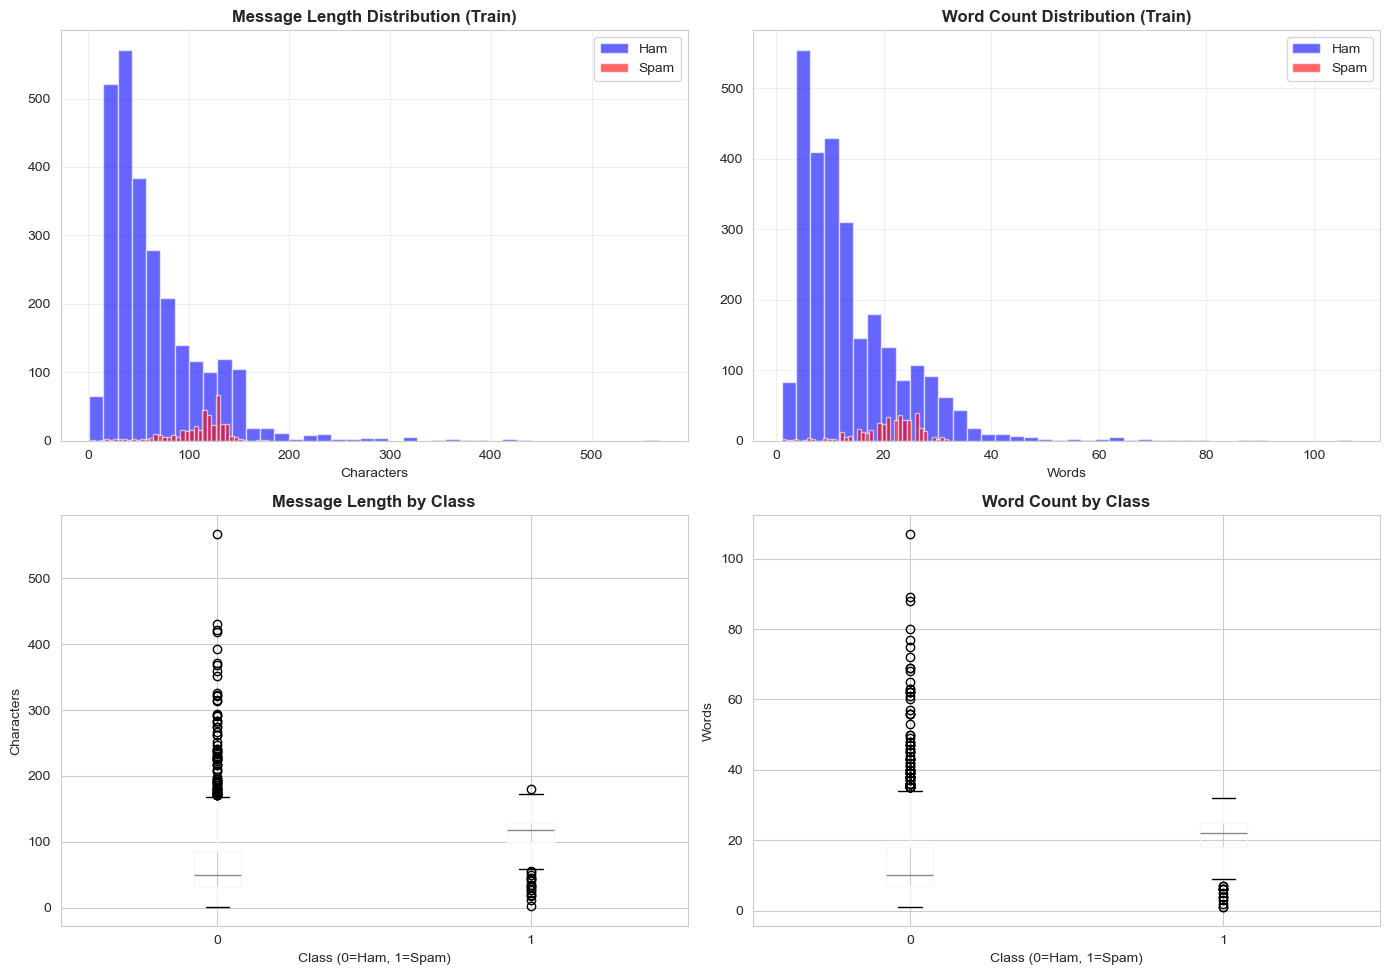


✓ Data loaded - ready for TF-IDF vectorization


In [2]:
# Load preprocessed splits
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/validation.csv')
test_df = pd.read_csv('../data/processed/test.csv')


# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print("="*60)
print("DATA LOADING SUMMARY")
print("="*60)

# Create summary table
split_summary = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Total': [len(train_df), len(val_df), len(test_df)],
    'Ham': [(y_train==0).sum(), (y_val==0).sum(), (y_test==0).sum()],
    'Spam': [y_train.sum(), y_val.sum(), y_test.sum()],
    'Spam %': [f"{100*y_train.mean():.2f}%", f"{100*y_val.mean():.2f}%", f"{100*y_test.mean():.2f}%"]
})
print(split_summary.to_string(index=False))

# Feature statistics by class
print(f"\n{'='*60}")
print("FEATURE STATISTICS (Training Set)")
print(f"{'='*60}")
print(train_df.groupby('label')[['message_length', 'word_count', 'avg_word_length']].describe().round(2))

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Message length by class
for label, color, name in [(0, 'blue', 'Ham'), (1, 'red', 'Spam')]:
    train_df[train_df['label']==label]['message_length'].hist(bins=40, alpha=0.6, 
                                                                label=name, color=color, ax=axes[0,0])
axes[0,0].set_title('Message Length Distribution (Train)', fontweight='bold')
axes[0,0].set_xlabel('Characters')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Word count by class
for label, color, name in [(0, 'blue', 'Ham'), (1, 'red', 'Spam')]:
    train_df[train_df['label']==label]['word_count'].hist(bins=40, alpha=0.6, 
                                                            label=name, color=color, ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution (Train)', fontweight='bold')
axes[0,1].set_xlabel('Words')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Boxplot comparison
train_df.boxplot(column='message_length', by='label', ax=axes[1,0])
axes[1,0].set_title('Message Length by Class', fontweight='bold')
axes[1,0].set_xlabel('Class (0=Ham, 1=Spam)')
axes[1,0].set_ylabel('Characters')

train_df.boxplot(column='word_count', by='label', ax=axes[1,1])
axes[1,1].set_title('Word Count by Class', fontweight='bold')
axes[1,1].set_xlabel('Class (0=Ham, 1=Spam)')
axes[1,1].set_ylabel('Words')

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\n✓ Data loaded - ready for TF-IDF vectorization")


## 2. Feature Extraction

TF-IDF VECTORIZATION COMPLETE
Vocabulary size: 3741
Sparsity: 99.80%

Train: (3100, 3741)
Val:   (1033, 3741)
Test:  (1034, 3741)


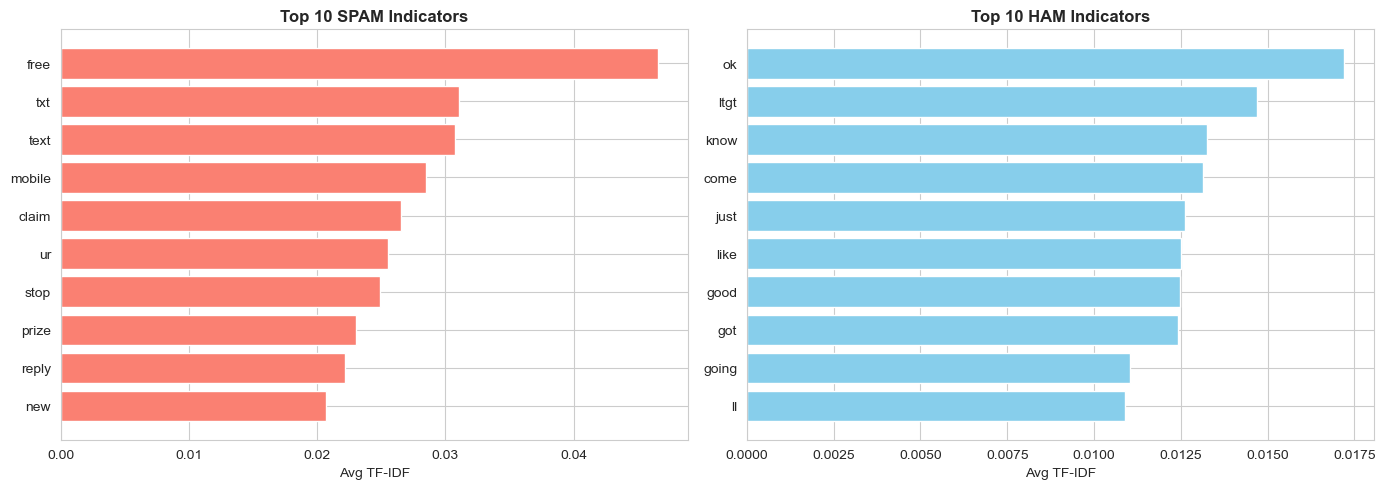


✓ Ready for model training


In [3]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train = vectorizer.fit_transform(train_df['message'])
X_val = vectorizer.transform(val_df['message'])
X_test = vectorizer.transform(test_df['message'])

print("="*60)
print("TF-IDF VECTORIZATION COMPLETE")
print("="*60)
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Sparsity: {100 * (1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1])):.2f}%")
print(f"\nTrain: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

# Top features by class
feature_names = vectorizer.get_feature_names_out()
spam_tfidf = X_train[y_train == 1].mean(axis=0).A1
ham_tfidf = X_train[y_train == 0].mean(axis=0).A1

top_spam = [(feature_names[i], spam_tfidf[i]) for i in spam_tfidf.argsort()[-10:][::-1]]
top_ham = [(feature_names[i], ham_tfidf[i]) for i in ham_tfidf.argsort()[-10:][::-1]]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh([w for w, _ in top_spam], [s for _, s in top_spam], color='salmon')
axes[0].set_xlabel('Avg TF-IDF')
axes[0].set_title('Top 10 SPAM Indicators', fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh([w for w, _ in top_ham], [s for _, s in top_ham], color='skyblue')
axes[1].set_xlabel('Avg TF-IDF')
axes[1].set_title('Top 10 HAM Indicators', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Ready for model training")


## 3. Model Training and Scoring

In [4]:
# MLflow experiment
mlflow.set_experiment("sms-spam-benchmarks")
client = MlflowClient()

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=2000, random_state=42, dual=True)
}

print("="*60)
print("BASELINE MODELS WITH MLFLOW TRACKING")
print("="*60)

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Log params
        mlflow.log_params({"model": name, "max_features": vectorizer.max_features})
        
        # Train
        model.fit(X_train, y_train)
        
        # Val predictions
        y_val_pred = model.predict(X_val)
        y_val_proba = None
        if hasattr(model, 'predict_proba'):
            y_val_proba = model.predict_proba(X_val)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_val_score = model.decision_function(X_val)
            y_val_proba = 1 / (1 + np.exp(-y_val_score))
        
        # AUCPR (key metric!)
        auprc = auprc_score(y_val, y_val_proba)
        mlflow.log_metric("auprc", auprc)
        
        # Other metrics
        mlflow.log_metric("accuracy", accuracy_score(y_val, y_val_pred))
        mlflow.log_metric("precision", precision_score(y_val, y_val_pred))
        mlflow.log_metric("recall", recall_score(y_val, y_val_pred))
        mlflow.log_metric("f1", f1_score(y_val, y_val_pred))
        
        # Log model & register
        mlflow.sklearn.log_model(model, "model")
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        registered_name = f"SMS-{name.replace(' ', '-')}"
        mlflow.register_model(model_uri, registered_name)
        
        print(f"✓ {name}: AUCPR={auprc:.4f}, Registered: {registered_name}")


2026/02/15 23:39:46 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/15 23:39:46 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/15 23:39:46 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/15 23:39:46 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/15 23:39:46 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/15 23:39:46 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/15 23:39:47 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/15 23:39:47 INFO mlflow.store.db.utils: Updating database tables
2026/02/15 23:39:47 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/15 23:39:47 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/15 23:39:47 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/15 23:3

BASELINE MODELS WITH MLFLOW TRACKING


2026/02/15 23:39:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'SMS-Logistic-Regression'.
2026/02/15 23:39:56 WARNING mlflow.tracking._model_registry.fluent: Run with id 11e7f1143919499db4fe4c521fffa573 has no artifacts at artifact path 'model', registering model based on models:/m-df5add6b319f4e96a34a4f50236b15f4 instead
Created version '1' of model 'SMS-Logistic-Regression'.
2026/02/15 23:39:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Logistic Regression: AUCPR=0.9452, Registered: SMS-Logistic-Regression


Successfully registered model 'SMS-Naive-Bayes'.
2026/02/15 23:40:02 WARNING mlflow.tracking._model_registry.fluent: Run with id 6c02377b5dcc4e96b5ba15b11c525a29 has no artifacts at artifact path 'model', registering model based on models:/m-d40ca752b0324023b8cc3d2d39ede354 instead
Created version '1' of model 'SMS-Naive-Bayes'.
2026/02/15 23:40:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Naive Bayes: AUCPR=0.9305, Registered: SMS-Naive-Bayes


Successfully registered model 'SMS-Linear-SVM'.
2026/02/15 23:40:09 WARNING mlflow.tracking._model_registry.fluent: Run with id 6bb3776320c54c51a8af59a0a04668af has no artifacts at artifact path 'model', registering model based on models:/m-b2b2d3bda55d4338b534aa05f50ca8a1 instead


✓ Linear SVM: AUCPR=0.9550, Registered: SMS-Linear-SVM


Created version '1' of model 'SMS-Linear-SVM'.



Logistic Regression:
  Accuracy:  0.9506
  Precision: 1.0000
  Recall:    0.6077
  F1:        0.7560
  F-beta(β=0.1): 0.9936

Naive Bayes:
  Accuracy:  0.9622
  Precision: 1.0000
  Recall:    0.7000
  F1:        0.8235
  F-beta(β=0.1): 0.9958

Linear SVM:
  Accuracy:  0.9797
  Precision: 0.9823
  Recall:    0.8538
  F1:        0.9136
  F-beta(β=0.1): 0.9808

BASELINE COMPARISON (Validation Set)
                     accuracy  precision  recall      f1  fbeta_0.1
Logistic Regression    0.9506     1.0000  0.6077  0.7560     0.9936
Naive Bayes            0.9622     1.0000  0.7000  0.8235     0.9958
Linear SVM             0.9797     0.9823  0.8538  0.9136     0.9808


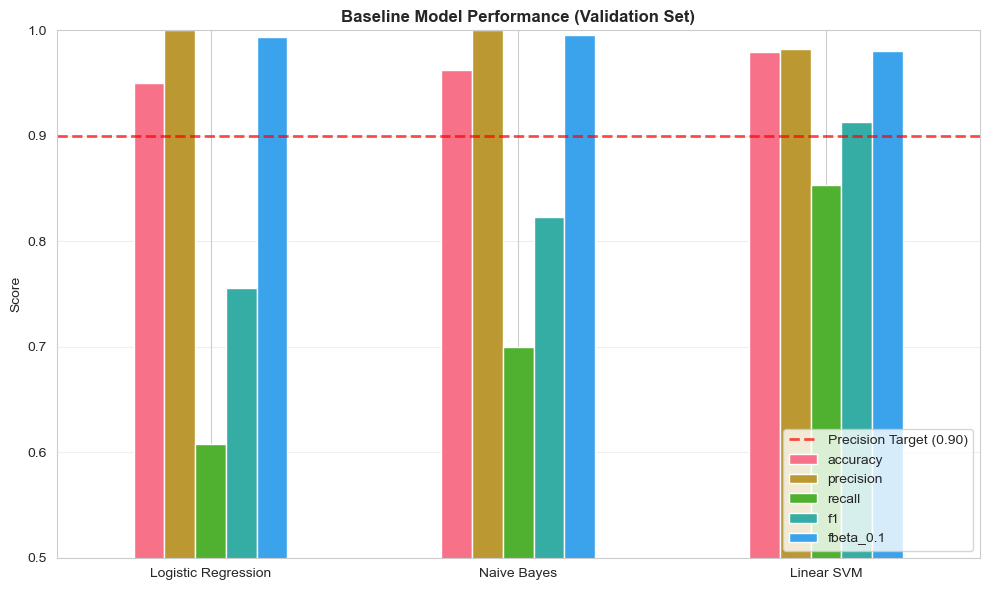


✓ Baseline training complete - ready for threshold optimization


In [7]:
baseline_results = {}

for name, model in models.items():
    print(f"\n{name}:")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict on validation
    y_val_pred = model.predict(X_val)
    
    # Get probabilities
    if hasattr(model, 'predict_proba'):
        y_val_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_val_score = model.decision_function(X_val)
        y_val_proba = 1 / (1 + np.exp(-y_val_score))
    
    # Calculate metrics
    baseline_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'fbeta_0.1': fbeta_score(y_val, y_val_pred, beta=0.1),
        'y_pred': y_val_pred,
        'y_proba': y_val_proba
    }
    
    print(f"  Accuracy:  {baseline_results[name]['accuracy']:.4f}")
    print(f"  Precision: {baseline_results[name]['precision']:.4f}")
    print(f"  Recall:    {baseline_results[name]['recall']:.4f}")
    print(f"  F1:        {baseline_results[name]['f1']:.4f}")
    print(f"  F-beta(β=0.1): {baseline_results[name]['fbeta_0.1']:.4f}")

# Comparison table
comparison_df = pd.DataFrame({
    name: {k: v for k, v in res.items() if k not in ['model', 'y_proba', 'y_pred']}
    for name, res in baseline_results.items()
}).T

print(f"\n{'='*60}")
print("BASELINE COMPARISON (Validation Set)")
print(f"{'='*60}")
print(comparison_df.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df[['accuracy', 'precision', 'recall', 'f1', 'fbeta_0.1']].plot(kind='bar', ax=ax, rot=0)
ax.set_title('Baseline Model Performance (Validation Set)', fontweight='bold', fontsize=12)
ax.set_ylabel('Score')
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Precision Target (0.90)')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

print("\n✓ Baseline training complete - ready for threshold optimization")

## 4. Model Evaluation

THRESHOLD OPTIMIZATION
Goal: Maximize Recall subject to Precision ≥ 90%

Logistic Regression:
  Optimal Threshold: 0.1908
  Precision: 0.9015
  Recall:    0.9154
  F1:        0.9084
  F-beta(β=0.1): 0.9017

Naive Bayes:
  Optimal Threshold: 0.1717
  Precision: 0.9055
  Recall:    0.8846
  F1:        0.8949
  F-beta(β=0.1): 0.9053

Linear SVM:
  Optimal Threshold: 0.4206
  Precision: 0.9015
  Recall:    0.9154
  F1:        0.9084
  F-beta(β=0.1): 0.9017


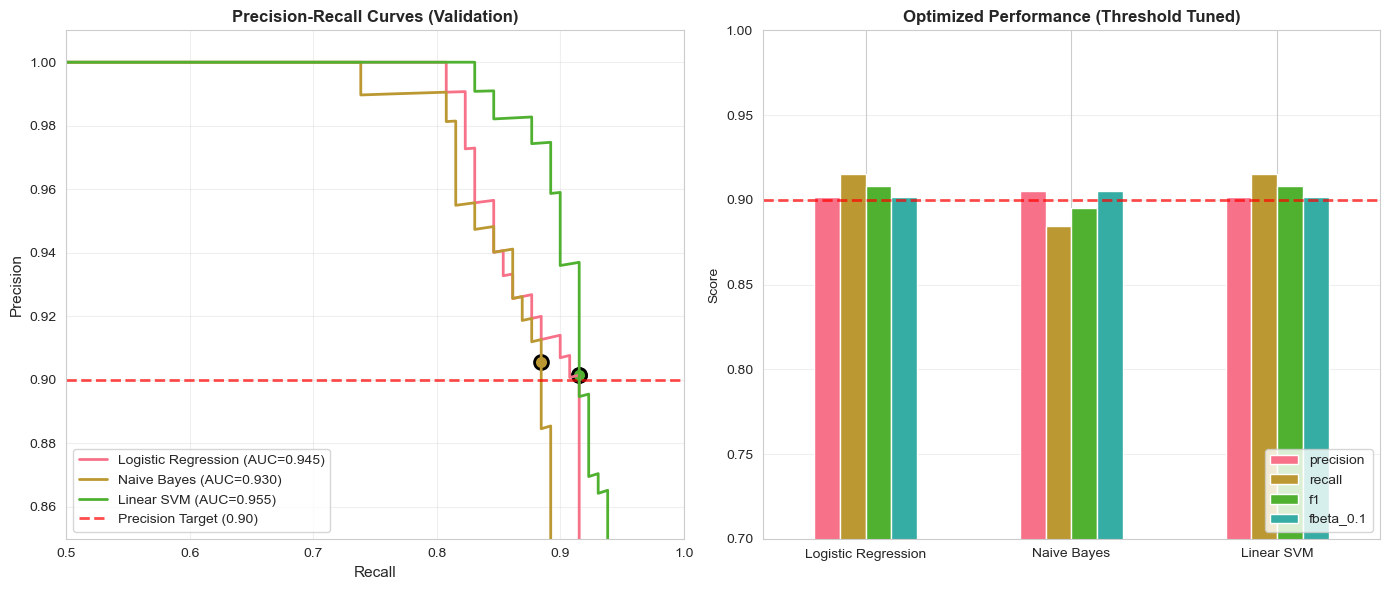


OPTIMIZED COMPARISON
                     threshold  precision  recall      f1  fbeta_0.1  accuracy
Logistic Regression     0.1908     0.9015  0.9154  0.9084     0.9017    0.9768
Naive Bayes             0.1717     0.9055  0.8846  0.8949     0.9053    0.9739
Linear SVM              0.4206     0.9015  0.9154  0.9084     0.9017    0.9768

✓ Threshold optimization complete!


In [8]:
# Threshold Optimization: Find optimal threshold for each model
# Goal: Maximize recall subject to precision ≥ 0.90

print("="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)
print("Goal: Maximize Recall subject to Precision ≥ 90%")

optimized_results = {}

for name, result in baseline_results.items():
    print(f"\n{name}:")
    
    y_proba = result['y_proba']
    
    # Compute precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
    
    # Find thresholds where precision >= 0.90
    valid_idx = np.where(precisions >= 0.90)[0]
    
    if len(valid_idx) > 0:
        # Among valid thresholds, pick the one with maximum recall
        best_idx = valid_idx[np.argmax(recalls[valid_idx])]
        optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
        optimal_precision = precisions[best_idx]
        optimal_recall = recalls[best_idx]
    else:
        # No threshold meets precision constraint, use default 0.5
        optimal_threshold = 0.5
        optimal_precision = result['precision']
        optimal_recall = result['recall']
    
    # Apply optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    
    optimized_results[name] = {
        'threshold': optimal_threshold,
        'precision': precision_score(y_val, y_pred_optimal),
        'recall': recall_score(y_val, y_pred_optimal),
        'f1': f1_score(y_val, y_pred_optimal),
        'fbeta_0.1': fbeta_score(y_val, y_pred_optimal, beta=0.1),
        'accuracy': accuracy_score(y_val, y_pred_optimal),
        'y_pred': y_pred_optimal,
        'precisions': precisions,
        'recalls': recalls,
        'thresholds_curve': thresholds
    }
    
    print(f"  Optimal Threshold: {optimal_threshold:.4f}")
    print(f"  Precision: {optimized_results[name]['precision']:.4f}")
    print(f"  Recall:    {optimized_results[name]['recall']:.4f}")
    print(f"  F1:        {optimized_results[name]['f1']:.4f}")
    print(f"  F-beta(β=0.1): {optimized_results[name]['fbeta_0.1']:.4f}")

# Visualize PR curves with optimal thresholds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Precision-Recall Curves
for name, result in optimized_results.items():
    pr_auc = auc(result['recalls'], result['precisions'])
    axes[0].plot(result['recalls'], result['precisions'], lw=2, 
                label=f'{name} (AUC={pr_auc:.3f})')
    
    # Mark optimal point
    axes[0].scatter(result['recall'], result['precision'], s=100, 
                   marker='o', edgecolors='black', linewidths=2)

axes[0].axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.7, 
               label='Precision Target (0.90)')
axes[0].set_xlabel('Recall', fontsize=11)
axes[0].set_ylabel('Precision', fontsize=11)
axes[0].set_title('Precision-Recall Curves (Validation)', fontweight='bold', fontsize=12)
axes[0].legend(loc='lower left')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0.5, 1.0])
axes[0].set_ylim([0.85, 1.01])

# Plot 2: Optimized Performance Comparison
opt_df = pd.DataFrame({
    name: {k: v for k, v in res.items() 
           if k in ['threshold', 'precision', 'recall', 'f1', 'fbeta_0.1', 'accuracy']}
    for name, res in optimized_results.items()
}).T

opt_df[['precision', 'recall', 'f1', 'fbeta_0.1']].plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Optimized Performance (Threshold Tuned)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Score')
axes[1].axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("OPTIMIZED COMPARISON")
print(f"{'='*60}")
print(opt_df.round(4))

print("\n✓ Threshold optimization complete!")


## 5. Validation and Hyperparameter Tuning

In [9]:
# Hyperparameter Tuning using GridSearchCV
print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)
print("Using GridSearchCV with 3-fold CV on training set")

tuned_models = {}

# Logistic Regression
print("\n1. Logistic Regression:")
param_grid_lr = {'C': [0.1, 1.0, 10.0], 'class_weight': ['balanced', None]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                        param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print(f"   Best params: {grid_lr.best_params_}")
print(f"   Best CV F1: {grid_lr.best_score_:.4f}")
tuned_models['Logistic Regression'] = grid_lr.best_estimator_

# Naive Bayes
print("\n2. Naive Bayes:")
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=3, scoring='f1', n_jobs=-1)
grid_nb.fit(X_train, y_train)
print(f"   Best params: {grid_nb.best_params_}")
print(f"   Best CV F1: {grid_nb.best_score_:.4f}")
tuned_models['Naive Bayes'] = grid_nb.best_estimator_

# Linear SVM
print("\n3. Linear SVM:")
param_grid_svm = {'C': [0.1, 1.0, 10.0], 'class_weight': ['balanced', None]}
grid_svm = GridSearchCV(LinearSVC(max_iter=2000, random_state=42, dual=True), 
                         param_grid_svm, cv=3, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)
print(f"   Best params: {grid_svm.best_params_}")
print(f"   Best CV F1: {grid_svm.best_score_:.4f}")
tuned_models['Linear SVM'] = grid_svm.best_estimator_

# Evaluate tuned models on validation set
print(f"\n{'='*60}")
print("TUNED MODELS - VALIDATION PERFORMANCE")
print(f"{'='*60}")

tuned_results = {}

for name, model in tuned_models.items():
    # Predict
    y_val_pred = model.predict(X_val)
    
    # Probabilities
    if hasattr(model, 'predict_proba'):
        y_val_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_val_score = model.decision_function(X_val)
        y_val_proba = 1 / (1 + np.exp(-y_val_score))
    
    tuned_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'fbeta_0.1': fbeta_score(y_val, y_val_pred, beta=0.1),
        'y_proba': y_val_proba
    }

# Comparison
tuned_df = pd.DataFrame({
    name: {k: v for k, v in res.items() if k not in ['model', 'y_proba']}
    for name, res in tuned_results.items()
}).T

print(tuned_df.round(4))

# Compare baseline vs tuned
print(f"\n{'='*60}")
print("IMPROVEMENT: Baseline → Tuned")
print(f"{'='*60}")

improvement_df = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'Baseline F1': [baseline_results[m]['f1'] for m in baseline_results.keys()],
    'Tuned F1': [tuned_results[m]['f1'] for m in tuned_results.keys()],
    'Δ F1': [tuned_results[m]['f1'] - baseline_results[m]['f1'] for m in tuned_results.keys()]
})
print(improvement_df.round(4))

print("\n✓ Hyperparameter tuning complete")


HYPERPARAMETER TUNING
Using GridSearchCV with 3-fold CV on training set

1. Logistic Regression:
   Best params: {'C': 10.0, 'class_weight': 'balanced'}
   Best CV F1: 0.8810

2. Naive Bayes:
   Best params: {'alpha': 0.1}
   Best CV F1: 0.8910

3. Linear SVM:
   Best params: {'C': 0.1, 'class_weight': 'balanced'}
   Best CV F1: 0.8730

TUNED MODELS - VALIDATION PERFORMANCE
                     accuracy  precision  recall      f1  fbeta_0.1
Logistic Regression    0.9777     0.9280  0.8923  0.9098     0.9276
Naive Bayes            0.9777     0.9652  0.8538  0.9061     0.9640
Linear SVM             0.9748     0.9062  0.8923  0.8992     0.9061

IMPROVEMENT: Baseline → Tuned
                 Model  Baseline F1  Tuned F1    Δ F1
0  Logistic Regression       0.7560    0.9098  0.1538
1          Naive Bayes       0.8235    0.9061  0.0826
2           Linear SVM       0.9136    0.8992 -0.0144

✓ Hyperparameter tuning complete


## 6. Test Evaluation with Optimized Thresholds

In [10]:
print("="*60)
print("FINAL TEST EVALUATION WITH MLFLOW")
print("="*60)

# MLflow runs for tuned models on test
for name in tuned_models.keys():
    with mlflow.start_run(run_name=f"{name}-test"):
        model = tuned_models[name]
        mlflow.log_param("model", name)
        mlflow.log_param("stage", "test-evaluation")
        
        # Test predictions
        y_test_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_test_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_test_score = model.decision_function(X_test)
            y_test_proba = 1 / (1 + np.exp(-y_test_score))
        
        # AUCPR on TEST (key metric!)
        test_auprc = auprc_score(y_test, y_test_proba)
        mlflow.log_metric("auprc_test", test_auprc)
        
        # Threshold-optimized metrics (your existing code)
        precisions_val, recalls_val, thresholds_val = precision_recall_curve(y_val, tuned_results[name]['y_proba'])
        valid_idx = np.where(precisions_val >= 0.90)[0]
        optimal_threshold = thresholds_val[valid_idx[np.argmax(recalls_val[valid_idx])]] if len(valid_idx) > 0 else 0.5
        
        y_test_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
        
        mlflow.log_metric("auprc_threshold_opt", auprc_score(y_test, y_test_proba))  # Still use proba
        mlflow.log_metric("precision_opt", precision_score(y_test, y_test_pred_opt))
        mlflow.log_metric("recall_opt", recall_score(y_test, y_test_pred_opt))
        mlflow.log_metric("f1_opt", f1_score(y_test, y_test_pred_opt))
        
        # Log tuned model again for test stage
        mlflow.sklearn.log_model(model, "tuned_model")
        
        print(f"✓ {name}: test AUCPR={test_auprc:.4f}")


2026/02/15 23:46:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


FINAL TEST EVALUATION WITH MLFLOW


2026/02/15 23:46:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Logistic Regression: test AUCPR=0.9790


2026/02/15 23:46:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Naive Bayes: test AUCPR=0.9693
✓ Linear SVM: test AUCPR=0.9673


## 7. Model Selection with threshold reoptimization

In [15]:
# SAFER - List recent runs with AUCPR
runs = client.search_runs(
    experiment_ids=[exp_id],
    max_results=10,
    order_by=["start_time DESC"]
)

print(f"\nRecent runs with AUCPR:")
for run in runs:
    auprc = run.data.metrics.get('auprc')
    if auprc is not None:
        print(f"{run.data.tags.get('mlflow.runName', 'Unknown')}: AUCPR={auprc:.4f}")



Recent runs with AUCPR:
Linear SVM: AUCPR=0.9550
Naive Bayes: AUCPR=0.9305
Logistic Regression: AUCPR=0.9452
